In [2]:
import os
import geopandas as gpd
import requests
import pandas as pd
import matplotlib.pyplot as plt


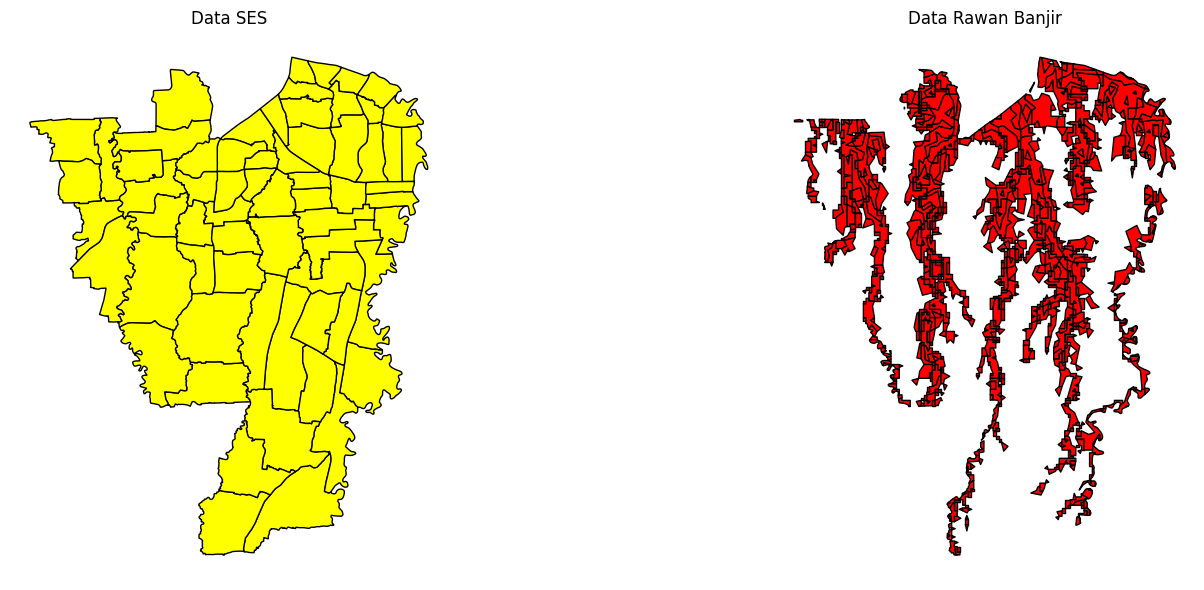

In [ ]:
# Analisis Hubungan Properti dijual dengan Tingkat Rawan Banjir Jakarta Selatan


#Mengambil data API
urls = {
    "SES": "https://geoserver.mapid.io/layers_new/get_layer?api_key=45d2dc7926f243efb255016b17ddfcb3&layer_id=68ac57cab2fcc5561a304c6a&project_id=68ab0b887fc5af9b4e437c30",
    "Rawan Banjir": "https://geoserver.mapid.io/layers_new/get_layer?api_key=45d2dc7926f243efb255016b17ddfcb3&layer_id=68ab0f35b2fcc5561a2e0961&project_id=68ab0b887fc5af9b4e437c30"
}

# Fungsi untuk mengambil data dan menambahkan kolom skor
def get_data(urls, layer_name):
    response = requests.get(urls)
    if response.status_code == 200:
        geojson_data = response.json()
        gdf = gpd.GeoDataFrame.from_features(geojson_data['features'])

# Menambahkan kolom skor layer
        if layer_name == "SES":
            gdf["SES"] = gdf.get("KELAS","").str.upper().map({"BAWAH": 1, "MENENGAH": 2, "ATAS": 3}).fillna(0)
        elif layer_name == "Rawan Banjir":
            gdf["SKOR_Banjir"] = gdf.get("Kelas", "").str.upper().map({"RENDAH": 3, "SEDANG": 2, "TINGGI": 1}).fillna(0)
    
        return gdf
    return gpd.GeoDataFrame()
    
# Ambil data untuk semua layer
gdf_ses = get_data(urls["SES"], "SES")
gdf_banjir = get_data(urls["Rawan Banjir"], "Rawan Banjir")

# Visualisasi data menggunakan matplotlib
def visualize_data(gdfs):
    fig, axes = plt.subplots(1, len(gdfs), figsize=(18, 6))
    color_map = ['yellow', 'red'] # Warna berbeda untuk setiap layer
    for ax, (name, gdf), color in zip(axes, gdfs.items(), color_map):
        gdf.plot(ax=ax, color=color, edgecolor='black')
        ax.set_title(name)
        ax.set_axis_off()
    plt.tight_layout()
    plt.show()

# Menampilkan visualisasi dari ketiga GeoDataFrame
visualize_data({"Data SES": gdf_ses, "Data Rawan Banjir": gdf_banjir})

In [19]:
# Memeriksa Nilai Null
gdf_ses['SES'] = gdf_ses['SES'].fillna(0)
gdf_banjir['SKOR_Banjir'] = gdf_banjir['SKOR_Banjir'].fillna(0)

# Intersection Layer
intersection_gdf = gdf_ses
if not gdf_banjir.empty:
    intersection_gdf = gpd.overlay(intersection_gdf, gdf_banjir, how='intersection', keep_geom_type =False)

# Memperbaiki geometri yang tidak valid setelah intersection
intersection_gdf = intersection_gdf[intersection_gdf.is_valid] # Menghapus geometri yang tidak valid
intersection_gdf['geometry'] = intersection_gdf['geometry'].apply(lambda x:
x.make_valid() if not x.is_valid else x)

# Perbaiki nilai NULL setelah intersection
intersection_gdf['SES'] = intersection_gdf['SES'].fillna(0)
intersection_gdf['SKOR_Banjir'] = intersection_gdf['SKOR_Banjir'].fillna(0)

#Hitung ulang skor total
intersection_gdf['SKOR_TOTAL'] = intersection_gdf['SES'] + intersection_gdf['SKOR_Banjir']

# Klasifikasi
intersection_gdf['KESESUAIAN'] = pd.cut(intersection_gdf['SKOR_TOTAL'],
bins=[2, 5, 7, 9], # Rentang/Interval Skor
labels=['RENDAH', 'SEDANG', 'TINGGI'],
include_lowest=True
)

print(intersection_gdf[['SES', 'SKOR_Banjir',
'SKOR_TOTAL', 'KESESUAIAN']].head(10))

   SES  SKOR_Banjir  SKOR_TOTAL KESESUAIAN
0    3          0.0         3.0     RENDAH
1    3          2.0         5.0     RENDAH
2    3          0.0         3.0     RENDAH
3    3          0.0         3.0     RENDAH
4    3          2.0         5.0     RENDAH
5    3          0.0         3.0     RENDAH
6    3          0.0         3.0     RENDAH
7    3          0.0         3.0     RENDAH
8    3          0.0         3.0     RENDAH
9    3          0.0         3.0     RENDAH


In [23]:
# Simpan semua hasil ke GeoJSON
import os
output_dir = r"C:\MAPID\WEBGIS_ACADEMY"
os.makedirs(output_dir, exist_ok=True)

# Filter hanya geometri Polygon dan MultiPolygon
intersection_gdf_polygons = intersection_gdf[intersection_gdf.geometry.type.isin(['Polygon', 'MultiPolygon'])]
# Perbaiki geometri yang tidak valid
intersection_gdf_polygons['geometry'] = intersection_gdf_polygons['geometry'].apply(lambda x: x.make_valid() if not
x.is_valid else x)

# Simpan Data Variabel

gdf_ses.to_file(os.path.join(output_dir, "SES.geojson"),
driver='GeoJSON')
gdf_banjir.to_file(os.path.join(output_dir,
"Rawan_Banjir.geojson"), driver='GeoJSON')

# Simpan hasil intersection yang telah diperbaiki ke GeoJSON
intersection_gdf_polygons.to_file(os.path.join(output_dir, "Hasil_Intersect.geojson"), driver='GeoJSON')

print(f"Data berhasil disimpan di: {output_dir}")
print("Semua file geojson telah berhasil disimpan.")

c:\MAPID\WEBGIS_ACADEMY\Lib\site-packages\pyogrio\geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
c:\MAPID\WEBGIS_ACADEMY\Lib\site-packages\pyogrio\geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
c:\MAPID\WEBGIS_ACADEMY\Lib\site-packages\pyogrio\geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


Data berhasil disimpan di: C:\MAPID\WEBGIS_ACADEMY
Semua file geojson telah berhasil disimpan.
